# Load gene data

In [1]:
try:
    # if this notebook is being called by another one
    # used passed gene_name value
    gene_name
except:
    # otherwise, set value to amacGFP / avGFP / cgreGFP / ppluGFP,
    # for instance for debugging here
    gene_name="cgreGFP"


In [2]:
recompute=False
# True: retrain all models
# False: try loading saved models, otherwise retrain models

Import modules
Define functions
Load cgreGFP data
cgreGFP 236 aa


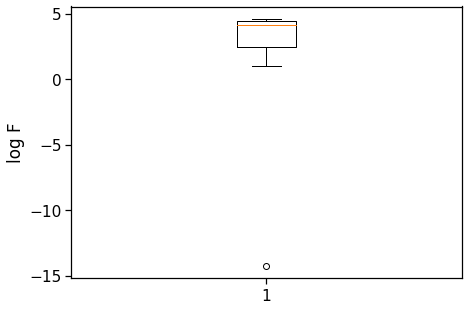

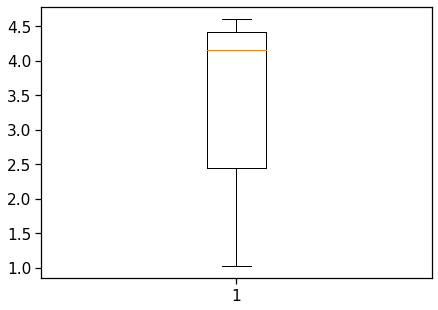

Pre-processing cgreGFP
Load cgreGFP encodings
Split train, valid, test sets
train_index 14199
valid_index 4733
test_index 4733


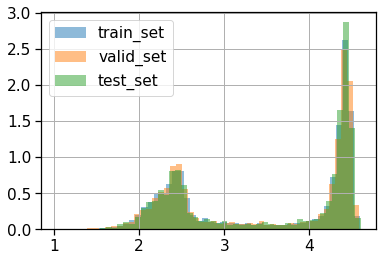

In [3]:
showmatrix=False
%run 01_preprocessing.ipynb

In [4]:
plot_range=(1,5)
plot_clim=None

if gene_name=="amacGFP":
    plot_range=(2,5)
    plot_clim=(1,200)
elif gene_name=="avGFP":
    plot_range=(1.3,5)
    plot_clim=(1,1000)
elif gene_name=="cgreGFP":
    plot_range=(1.5,5)
    plot_clim=(1,300)
elif gene_name=="ppluGFP":
    plot_range=(2,5)
    plot_clim=(1,200)


In [5]:
# create folder for saving figures and data of figures
try:mkdir("_08_Figures/")
except:pass
try:mkdir("_08_Figures/for_paper")
except:pass

# Linear model

In [6]:
model_file = join(modelsPath,f"{gene_name}_lm.h5")

try:
    if recompute:raise
    lm = pickle.load(open(model_file, 'rb'))
    score = lm.score(predictors_train, target_train)
    print("Found",model_file,"- score",score)
except:
    lm = LinearRegression()
    lm.fit(predictors_train,target_train)
    score = lm.score(predictors_train,target_train)
    print("score",score)
    
    pickle.dump(lm, open(model_file, 'wb'))


Found _04_Models/cgreGFP_lm.h5 - score 0.6571549408068055


r2 -9891558679644750183661568.000


<Figure size 792x720 with 0 Axes>

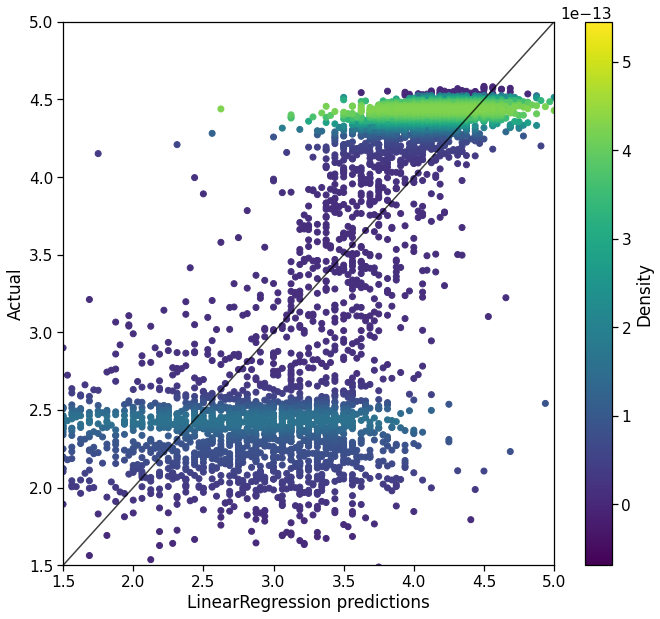

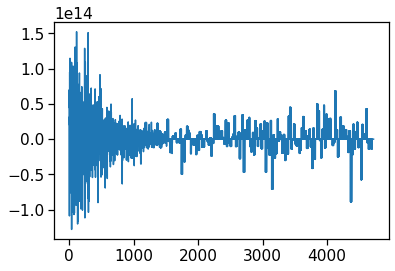

In [7]:
predictions = lm.predict(predictors_valid)

y_true = target_valid.values
y_pred = predictions


r2_valid = r2_score(y_true=y_true,y_pred=y_pred)
print("r2 %.3f" % r2_valid)

fig = plt.figure(figsize=(11, 10))

fig.patch.set_facecolor('w')
density_scatter(predictions.flatten(),target_valid.values.flatten(), bins = [30,30] )
plt.xlabel("LinearRegression predictions")
plt.ylabel("Actual")
plt.plot(plot_range,plot_range, 'k-', alpha=0.75, zorder=1)
plt.xlim(plot_range)
plt.ylim(plot_range)
plt.show()

fig, ax = plt.subplots()
fig.patch.set_facecolor('w')
plt.plot(lm.coef_.flatten())

plt.show()


This needs regularization.

# Fit Ridge

In [8]:
# constraining weights using ridge regression.
model_file = join(modelsPath,f"{gene_name}_ridge.h5")


try:
    if recompute:raise
    ridge = pickle.load(open(model_file, 'rb'))
    score = ridge.score(predictors_train, target_train)
    print("Found",model_file,"- score",score)
    
except:
    #find best alpha
    regr_cv = RidgeCV(alphas=[0.1, 1.0, 10.0,100.0])
    model_cv = regr_cv.fit(predictors_train, target_train)
    
    # retrain
    ridge = Ridge(alpha=model_cv.alpha_)
    ridge.fit(predictors_train,target_train) 
    pickle.dump(ridge, open(model_file, 'wb'))



Found _04_Models/cgreGFP_ridge.h5 - score 0.6602019174860039


np.multiply(predictors_valid.iloc[0].values,ridge.coef_).sum() + ridge.intercept_ [3.34877275]
ridge_predictions[0][3.34877275]
r2 0.605


<Figure size 792x720 with 0 Axes>

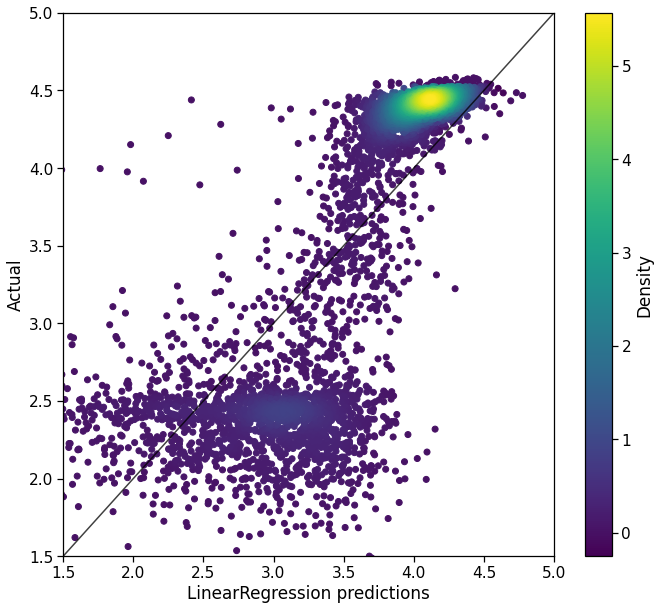

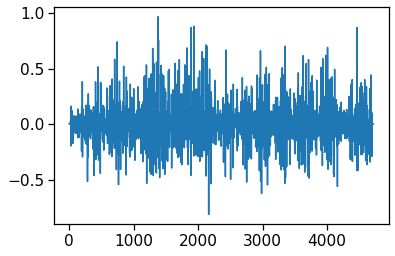

In [9]:
ridge_predictions = ridge.predict(predictors_valid)

fig = plt.figure(figsize=(11, 10))
fig.patch.set_facecolor('w')

density_scatter(ridge_predictions.flatten(),
                target_valid.values.flatten(), 
                bins = [30,30],
                norm_min=None,
                norm_max=None)

plt.xlabel("LinearRegression predictions")
plt.ylabel("Actual")
plt.plot(plot_range, plot_range, 'k-', alpha=0.75, zorder=1)
plt.xlim(plot_range)
plt.ylim(plot_range)

fig, ax = plt.subplots()
fig.patch.set_facecolor('w')
plt.plot(ridge.coef_.flatten())

# just checking
print(f"np.multiply(predictors_valid.iloc[0].values,ridge.coef_).sum() + ridge.intercept_ {np.multiply(predictors_valid.iloc[0].values,ridge.coef_).sum() + ridge.intercept_}")
print(f"ridge_predictions[0]{ridge_predictions[0]}")
y_true = target_valid.values
y_pred = ridge_predictions


r2_valid = r2_score(y_true=y_true,
                    y_pred=y_pred)

print("r2 %.3f" % r2_valid)


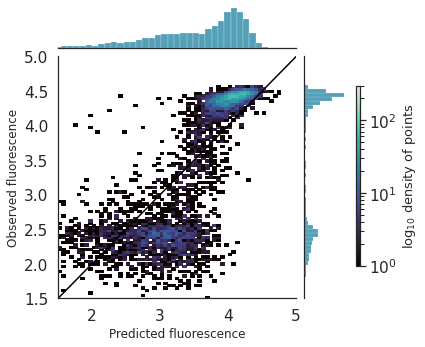

In [10]:
results=pd.DataFrame({"Predicted fluorescence":flatten(y_pred),"Observed fluorescence":flatten(y_true)})
makenicegraph(results,
               x="Predicted fluorescence",
               y="Observed fluorescence",plot_clim=plot_clim)

# save data for recap figure

results.to_csv(f"{figuresPath}for_paper/{gene_name}_ridge.csv")

# Fit a linear model using keras

In [11]:
# one layer of one node  
# with linear activation function
# to mimick linear model

model_file = modelsPath+gene_name+"_lm_with_NN.h5"

try:
    if recompute:raise
    lm_with_NN = keras.models.load_model(model_file)
    print("Found",model_file,"- score",score)
    
except:
    
    input_shape = predictors_train.shape[1]
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    inputs = Input(shape=(predictors_train.shape[1],))
    predictions = Dense(1,activation="linear")(inputs)

    optimizer = keras.optimizers.Adam()

    lm_with_NN = Model(inputs=inputs, outputs=predictions)
    lm_with_NN.compile(optimizer=optimizer,
                        loss="mean_squared_error",
                       metrics=['mae'])
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    early_stopping_monitor = EarlyStopping(patience=10)
    checkpoint_filepath="./tmp_mdl_checkpoint"
    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                mode='min',
                                                save_best_only=True)    
    
    lm_with_NN.fit(predictors_train.values,target_train.values,
                   validation_data=(predictors_valid.values,target_valid.values),
                   epochs=30,
                   shuffle=True,
                   callbacks=[early_stopping_monitor,model_checkpoint_callback])
    
    lm_with_NN.load_weights(checkpoint_filepath)
    
    lm_with_NN.save(model_file)



Found _04_Models/cgreGFP_lm_with_NN.h5 - score 0.6602019174860039


r2 0.596


<Figure size 792x720 with 0 Axes>

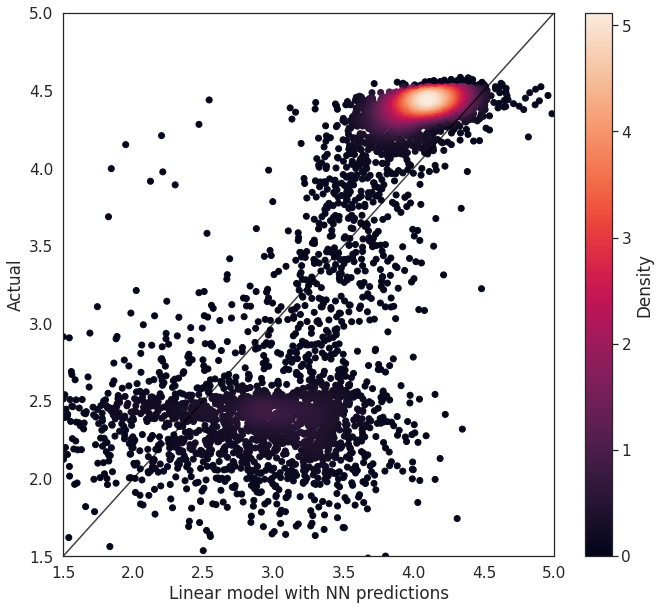

In [12]:
predictions_lm_with_NN = lm_with_NN.predict(predictors_valid)

y_true = target_valid.values
y_pred = predictions_lm_with_NN


r2_valid = r2_score(y_true=y_true,
                    y_pred=y_pred)

print("r2 %.3f" % r2_valid)

fig = plt.figure(figsize=(11, 10))
fig.patch.set_facecolor('w')
density_scatter(predictions_lm_with_NN.flatten(),
                target_valid.values.flatten(),
                bins = [30,30],
                norm_min=None,
                norm_max=None)

plt.xlabel("Linear model with NN predictions")
plt.ylabel("Actual")
plt.xlim(plot_range)
plt.ylim(plot_range)

plt.plot(plot_range,plot_range, 'k-', alpha=0.75, zorder=1)
plt.show()


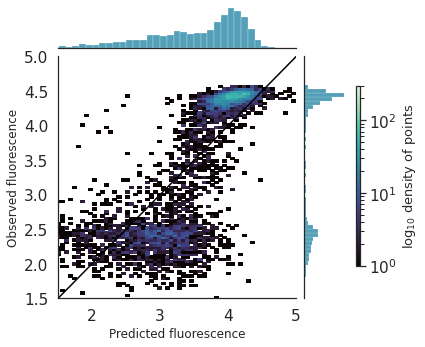

In [13]:
results=pd.DataFrame({"Predicted fluorescence":flatten(y_pred),"Observed fluorescence":flatten(y_true)})
makenicegraph(results,
               x="Predicted fluorescence",
               y="Observed fluorescence",plot_clim=plot_clim)

# save data for recap figure
results.to_csv(f"{figuresPath}for_paper/{gene_name}_lm_with_NN.csv")

In [14]:
lm_with_NN.count_params()


4721

# Fit linear model with 1 sigmoid node

In [15]:
model_file = modelsPath+gene_name+"_sigmoid_with_NN.h5"

try:
    if recompute:raise
    sigmoid_model_with_NN = keras.models.load_model(model_file)
    print("Found",model_file,"- score",score)
    
except:
    
    #A multiple regression where mutations contribute linearly to a fitness potential
    # and fluorescence is a sigmoidal function of p where F ~ e−p/(1+e−p)
    
    
    inputs = Input(shape=(predictors_train.shape[1],))
    sigmoid = Dense(1,activation="sigmoid")(inputs)
    predictions = Dense(1,activation="linear")(sigmoid)

    optimizer = keras.optimizers.Adam()

    sigmoid_model_with_NN = Model(inputs=inputs, outputs=predictions)
    sigmoid_model_with_NN.compile(optimizer=optimizer,
                        loss="mean_squared_error",
                        metrics=['mae'])
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    early_stopping_monitor = EarlyStopping(patience=10)
    checkpoint_filepath="./tmp_mdl_checkpoint"
    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                mode='min',
                                                save_best_only=True)
    
    out=sigmoid_model_with_NN.fit(predictors_train.values,target_train.values,
                              validation_data=(predictors_valid.values,target_valid.values),
                              epochs=30,
                              shuffle=True,
                              callbacks=[early_stopping_monitor,model_checkpoint_callback])
    
    sigmoid_model_with_NN.load_weights(checkpoint_filepath)
    
    sigmoid_model_with_NN.save(model_file)
        

Found _04_Models/cgreGFP_sigmoid_with_NN.h5 - score 0.6602019174860039


r2 0.628


<Figure size 792x720 with 0 Axes>

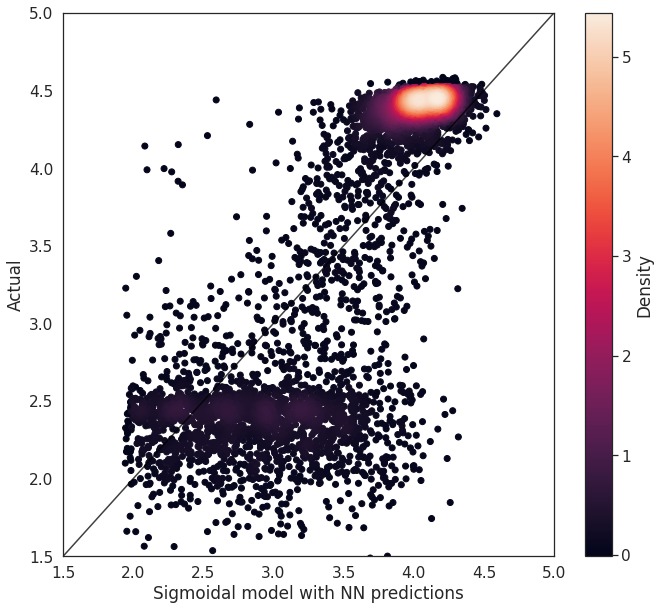

In [16]:
predictions_sigmoid_model_with_NN = sigmoid_model_with_NN.predict(predictors_valid)

y_true = target_valid.values
y_pred = predictions_sigmoid_model_with_NN


r2_valid = r2_score(y_true=y_true,
                          y_pred=y_pred)

print("r2 %.3f" % r2_valid)

fig = plt.figure(figsize=(11, 10))
fig.patch.set_facecolor('w')
density_scatter(predictions_sigmoid_model_with_NN.flatten(),
                target_valid.values.flatten(), 
                bins = [30,30],
                norm_min=None,
                norm_max=None)
plt.xlabel("Sigmoidal model with NN predictions")
plt.ylabel("Actual")
plt.xlim(plot_range)
plt.ylim(plot_range)

plt.plot(plot_range,plot_range, 'k-', alpha=0.75, zorder=1)
plt.show()

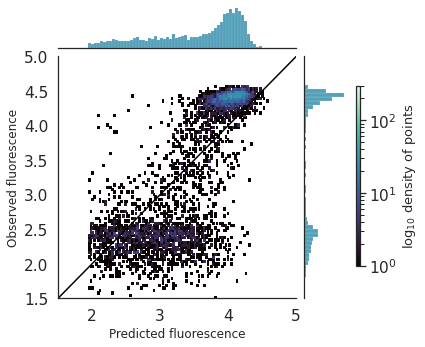

In [17]:
results=pd.DataFrame({"Predicted fluorescence":flatten(y_pred),"Observed fluorescence":flatten(y_true)})
makenicegraph(results,
               x="Predicted fluorescence",
               y="Observed fluorescence",plot_clim=plot_clim)

# save data for recap figure
results.to_csv(f"{figuresPath}for_paper/{gene_name}_sigmoid.csv")

# Fit 1, 10, 1 model

In [18]:
model_file = modelsPath+gene_name+"_1_10_1_NN.h5"

try:
    if recompute:raise
        
    FF_1_10_1_model = keras.models.load_model(model_file)
    print("Found",model_file,"- score",score)
    
except:
    
    inputs = Input(shape=(predictors_train.shape[1],))
    hidden = Dense(1,activation="linear",name="L1")(inputs)
    hidden = Dense(10,activation="sigmoid",name="L2")(hidden)
    predictions = Dense(1,activation="linear",name="L3")(hidden)

    optimizer = keras.optimizers.Adam()

    FF_1_10_1_model = Model(inputs=inputs, outputs=predictions)
    FF_1_10_1_model.compile(optimizer=optimizer,
                        loss="mean_squared_error")
    
    early_stopping_monitor = EarlyStopping(patience=10)
    checkpoint_filepath="./tmp_mdl_checkpoint"
    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                mode='min',
                                                save_best_only=True)
    
    FF_1_10_1_model.fit(predictors_train.values,target_train.values,
                        validation_data=(predictors_valid.values,target_valid.values),
                        epochs=30,
                        shuffle=True,
                        callbacks=[early_stopping_monitor,model_checkpoint_callback])
    
    FF_1_10_1_model.load_weights(checkpoint_filepath)

    FF_1_10_1_model.save(model_file)


FF_1_10_1_model.summary()

Found _04_Models/cgreGFP_1_10_1_NN.h5 - score 0.6602019174860039
Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4720)]            0         
_________________________________________________________________
L1 (Dense)                   (None, 1)                 4721      
_________________________________________________________________
L2 (Dense)                   (None, 10)                20        
_________________________________________________________________
L3 (Dense)                   (None, 1)                 11        
Total params: 4,752
Trainable params: 4,752
Non-trainable params: 0
_________________________________________________________________


r2 0.861


<Figure size 792x720 with 0 Axes>

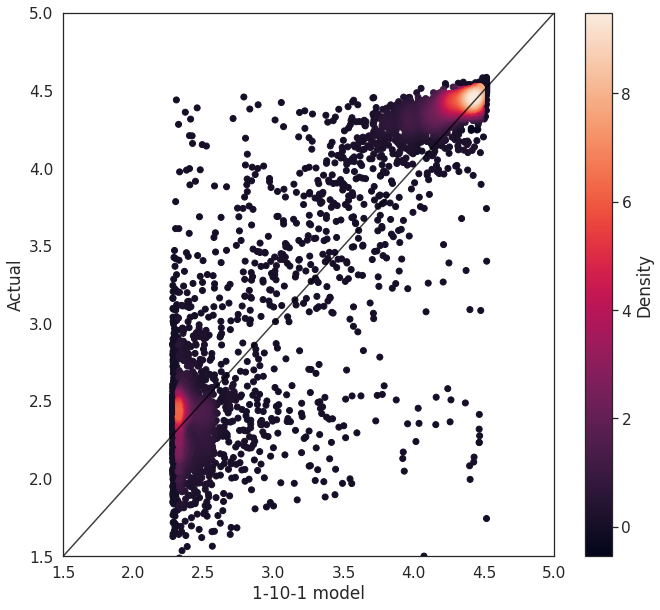

In [19]:
predictions_FF_1_10_1_model = FF_1_10_1_model.predict(predictors_valid)

y_true = target_valid.values
y_pred = predictions_FF_1_10_1_model.flatten()


r2_valid = r2_score(y_true=y_true,
                          y_pred=y_pred)

print("r2 %.3f" % r2_valid)

fig = plt.figure(figsize=(11, 10))

fig.patch.set_facecolor('w')
density_scatter(predictions_FF_1_10_1_model.flatten(),
                target_valid.values.flatten(),
                bins = [30,30],
                norm_min=None,
                norm_max=None)

plt.xlabel("1-10-1 model")
plt.ylabel("Actual")
plt.xlim(plot_range)
plt.ylim(plot_range)

plt.plot(plot_range,plot_range, 'k-', alpha=0.75, zorder=1)
plt.show()

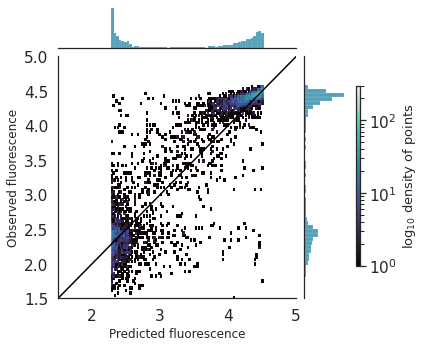

In [20]:
results=pd.DataFrame({"Predicted fluorescence":y_pred,"Observed fluorescence":flatten(y_true)})

makenicegraph(results,
              x="Predicted fluorescence",
              y="Observed fluorescence",
              plot_clim=plot_clim)

# save data for recap figure
results.to_csv(f"{figuresPath}for_paper/{gene_name}_output_subnetwork.csv")

## Plot function that the network comes up with

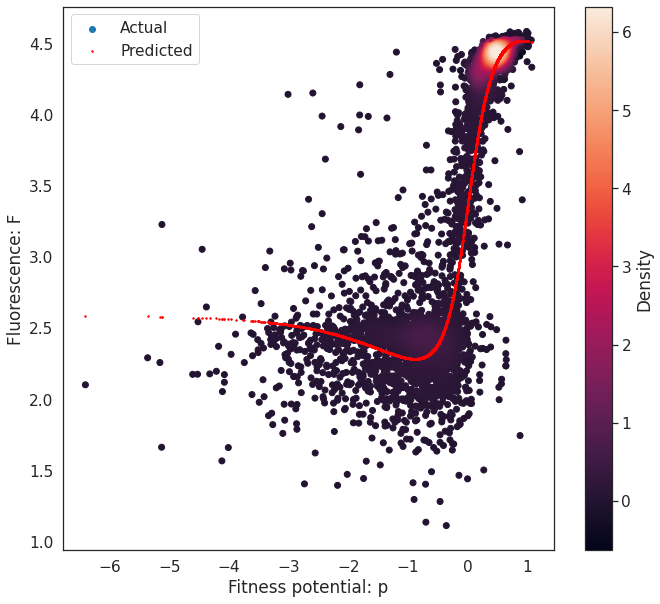

In [21]:
# here, we create sub- models to compute the outputs of the different layers
#  on validation set 

# function to compute fitness potential p from predictors
layer_name = 'L1'
L0_model = Model(inputs=FF_1_10_1_model.input,outputs=FF_1_10_1_model.get_layer(layer_name).output)

# function to compute fluorescence F from predictors
layer_name = 'L2'
L1_model = Model(inputs=FF_1_10_1_model.input,outputs=FF_1_10_1_model.get_layer(layer_name).output)

# function to compute fluorescence F from predictors
layer_name = 'L3'
L2_model = Model(inputs=FF_1_10_1_model.input,outputs=FF_1_10_1_model.get_layer(layer_name).output)

# compute p and F for each record in the validing set
p = L0_model.predict(predictors_valid).flatten()
F = L2_model.predict(predictors_valid).flatten()

p_to_F = pd.DataFrame(list(zip(p,F)),columns=["p","F"])

# -------------------------------------------------

x = p_to_F.p.values
y = target_valid.values.flatten()


s1 = density_scatter(x, y, bins = [30,30],
                     norm_min=None,
                     norm_max=None)

s2 = plt.scatter(p_to_F.p.values, p_to_F.F.values, s=2,color='r')


plt.xlabel("Fitness potential: p")
plt.ylabel("Fluorescence: F")


plt.legend(("Actual","Predicted"))
plt.show()

In [22]:
results=pd.DataFrame({"potential":p,"Predicted fluorescence":F,"Observed fluorescence":y})
results.to_csv(f"{figuresPath}for_paper/{gene_name}_p_to_F.csv")

# Scan for best architecture

In [23]:
dropout_rate = 0.1
optimizer = keras.optimizers.Adam()

def optimize_model(x_train, y_train, x_val, y_val, params):
    
    def fitted_model(x_train, y_train, x_val, y_val, params):
        
        inputs = Input(shape=(predictors_train.shape[1],))
        hidden1 = Dense(int(params["neurons_in_1st_h_layer"]),activation="linear",name="L1")(inputs)
        dropout1 = Dropout(dropout_rate,name="D1")(hidden1)
        hidden2 = Dense(int(params["neurons_in_2nd_h_layer"]),activation="sigmoid",name="L2")(dropout1)
        dropout2 = Dropout(dropout_rate,name="D2")(hidden2)
        predictions = Dense(1,activation="linear")(dropout2)        
        
        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer=optimizer,loss="mean_squared_error",metrics=['mae'])

        out = model.fit(x_train,y_train,
                        validation_data=[x_val,y_val],
                       epochs=20,
                       shuffle=True)

        return out, model

    scan_object = talos.Scan(x=x_train,
                             y=y_train,
                             x_val=x_val,
                             y_val=y_val,
                             model=fitted_model,
                             experiment_name="fit N-N-1",
                             params=params,
                             fraction_limit=0.1,
                             reduction_metric='val_loss',
                             minimize_loss=True,
                             print_params=True,
                             random_method="quantum")

    return scan_object

In [24]:
# create parameter dict
params = {}
params["neurons_in_1st_h_layer"] = [*range(1,11)]+[20,50,100,200]
params["neurons_in_2nd_h_layer"] = [*range(1,11)]+[20,50,100,200]

In [25]:

opt_file = modelsPath+gene_name+"_talos_optim.csv"

try: 
    optimisation_results = pd.read_csv(opt_file)
    
except:
    optimisation_results = optimize_model(x_train=predictors_train.values,
                                          y_train=target_train.values,
                                          x_val=predictors_valid.values,
                                          y_val=target_valid,
                                          params=params)
    
    optimisation_results.data.to_csv(opt_file)
    optimisation_results = pd.read_csv(opt_file)

In [26]:
best_Hparams = optimisation_results.loc[optimisation_results["val_loss"].argmin(),:]
best_Hparams

Unnamed: 0                  4.000000
round_epochs               10.000000
val_loss                    0.187551
val_mae                     0.242268
loss                        0.183471
mae                         0.294642
neurons_in_1st_h_layer    200.000000
neurons_in_2nd_h_layer    200.000000
Name: 4, dtype: float64

In [27]:
def make_model():
    inputs = Input(shape=(predictors_train.shape[1],))
    hidden1 = Dense(int(best_Hparams["neurons_in_1st_h_layer"]),activation="linear")(inputs)
    dropout1 = Dropout(dropout_rate,name="D1")(hidden1,training=True)
    hidden2 = Dense(int(best_Hparams["neurons_in_2nd_h_layer"]),activation="sigmoid")(dropout1)
    dropout2 = Dropout(dropout_rate,name="D2")(hidden2,training=True)
    predictions = Dense(1,activation="linear")(dropout2)
    
    optimizer = keras.optimizers.Adam()
    
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer=optimizer,
                  loss="mean_squared_error",
                  metrics=['mae'])
    return(model)

# Train best architecture

In [28]:
# Train with best parameters

model_file = modelsPath+gene_name+"_N1_N2_1_NN_optimized.h5"
print(model_file)

try:
    if recompute:raise
    optimised_model = keras.models.load_model(model_file)
    print("Found",model_file)
    
except:
    
    dropout_rate = 0.1
    
    # create and fit model with best Hparams
    optimised_model=make_model()    
    
    early_stopping_monitor = EarlyStopping(patience=10)
    
    checkpoint_filepath="./tmp_mdl_checkpoint"
    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                mode='min',
                                                save_best_only=True)
    
    out = optimised_model.fit(predictors_train.values,target_train.values,
                              validation_data=(predictors_valid.values,target_valid.values),
                              epochs=100,
                              shuffle=True,
                              batch_size=100,
                              callbacks=[early_stopping_monitor,model_checkpoint_callback])
    
    optimised_model.load_weights(checkpoint_filepath)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.patch.set_facecolor('w')

    plt.plot(out.history['val_loss'], 'r')
    plt.plot(out.history['loss'], 'k')

    plt.xlabel('Epochs')
    plt.ylabel('Validation score')

    plt.legend(("Validation set","Training set"))

    plt.show()

    optimised_model.save(model_file)

optimised_model.summary()


_04_Models/cgreGFP_N1_N2_1_NN_optimized.h5
Found _04_Models/cgreGFP_N1_N2_1_NN_optimized.h5
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 4720)]            0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               944200    
_________________________________________________________________
D1 (Dropout)                 (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               40200     
_________________________________________________________________
D2 (Dropout)                 (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 984,601
Train

In [29]:
# takes a bit of time, as the model predicts 10 times each genotype

train_set_muts = sorted(list(flatten([ elt.split(":") for elt in df.loc[train_index,:][genotype_col].values.flatten()])))
train_set_muts_unique = sorted(list(set(train_set_muts)))
counts_in_training_set=Counter(train_set_muts)

#-------------------------------
predictions_=pd.DataFrame(np.concatenate([optimised_model.predict(predictors_valid.values) for i in range(10)],axis=1),
                          index=predictors_valid.index)

predictions_median=pd.DataFrame(np.median(predictions_,axis=1),
                                index=predictors_valid.index,
                                columns=["median"])

predictions_std=pd.DataFrame(predictions_.std(axis=1),
                             index=predictors_valid.index,
                             columns=["std"])

predictions_as_df = pd.concat([df.loc[valid_index,:][[genotype_col]],
                               predictions_median,
                               predictions_std],
                              axis=1)

# find for each validation genotype the mutation with the min number of occurences
predictions_as_df["min_nb_of_contexts"] = predictions_as_df[genotype_col].apply(lambda x:min([counts_in_training_set.get(elt,0) for elt in x.split(":")]))


r2 0.858


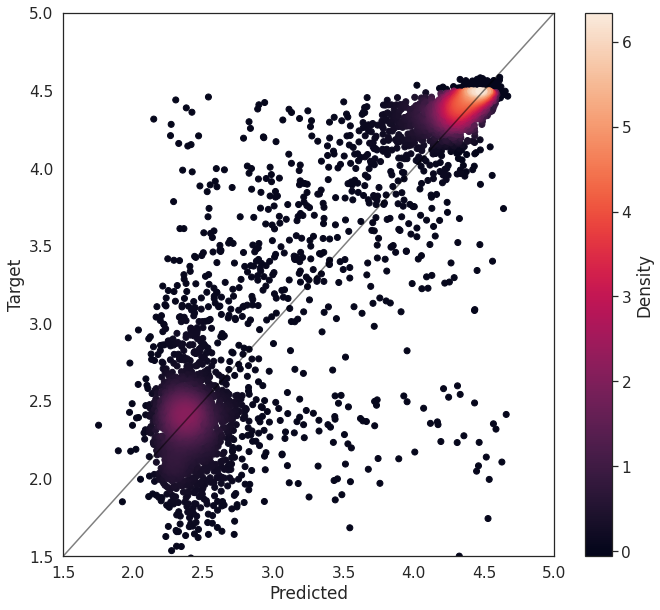

In [30]:

pred = predictions_median.values.flatten()
tar = target_valid.values.flatten()

r2_valid = r2_score(y_true=tar,y_pred=pred)
print("r2 %.3f" % r2_valid)

density_scatter(pred,tar, ax = None, sort = True, bins = 20)

plt.xlim(plot_range) 
plt.ylim(plot_range)  
plt.xlabel("Predicted")
plt.ylabel("Target")
plt.plot(plot_range,plot_range,color="k",alpha=0.5)

plt.show()



# Decide on minimal number of training samples/mutation w.r.t model uncertainty

We want to make sure the training set contains all mutations at least a certain number of times.<br>
Plotting the uncertainty of predictions w.r.t the number of training samples/mutation: <br><br>

for each genotype in the validation set, <br>
we calculate which mutation has been trained the fewest times which gives us "that number"<br>
then we plot the distribution of standard deviations of predicted validation genotypes<br>
binned by "that number". We expect Stds to decrease as the number of training occurences increases.

In [31]:

cut = 1 # cumulate data every "cut" number of occurences
violin_max =  20 # maximum number of violins to show
number_of_values_cap = 500 # max number of values to sample

col = "std" # column that we want to plot
by = "min_nb_of_contexts" # column to sort by

# get number of contexts sorted
sorted_occurence_nbs = sorted(predictions_as_df[by].unique())
# split nb_contexts in bins every so often (cut) values
ticks = [sorted_occurence_nbs[i] for i in range(0,len(sorted_occurence_nbs),cut)][:violin_max]

number_of_values_totals = {}
number_of_values_plotted = {}

dataset =[]
for i in ticks[:-1]:
    # get genotypes where muts have been trained a certain number of times (within interval)
    subset = predictions_as_df[(predictions_as_df.min_nb_of_contexts >=i) & (predictions_as_df.min_nb_of_contexts <ticks[ticks.index(i)+1])]
    subset = subset[[col]]
    
    number_of_values_totals[i] =subset.shape[0]
    try:
        subset = subset.sample(number_of_values_cap)
    except:
        pass
    subset=subset.values.flatten()
    dataset.append(subset)
    number_of_values_plotted[i] = subset.shape[0]


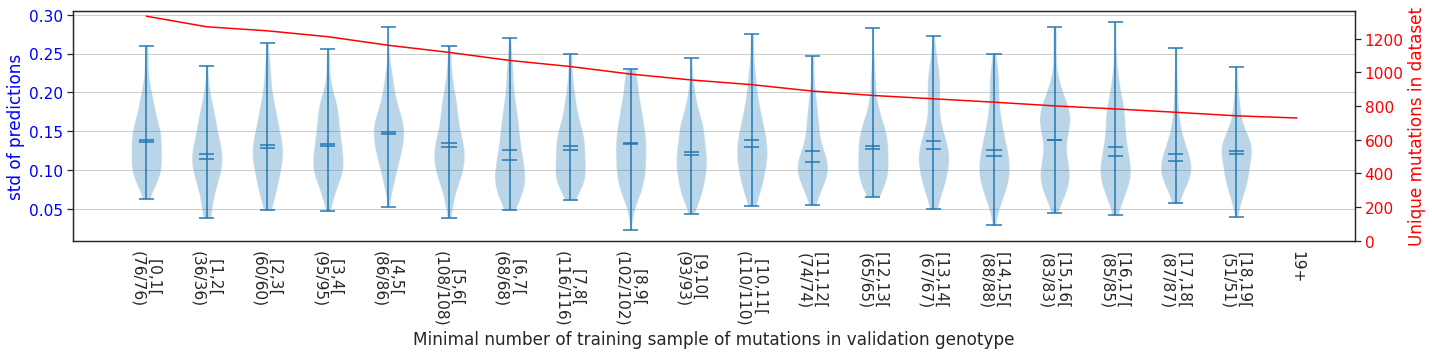

In [32]:
fig, ax = plt.subplots(figsize=(20, 5))
fig.patch.set_facecolor('w')


ax.violinplot(dataset=dataset,showmeans=True,showmedians=True)

ax.yaxis.grid(True)
ax.set_xlabel('Minimal number of training sample of mutations in validation genotype')
ax.set_ylabel(col+" of predictions", color="b")
ax.tick_params(axis='y', labelcolor="b")

ax.set_xticks([i+1 for i in range(len(ticks))])
labels = [f"[{tick},{ticks[ticks.index(tick)+1]}[ \n({number_of_values_plotted[tick]}/{number_of_values_totals[tick]})" for tick in ticks[:-1]] + [f"{ticks[ticks.index(ticks[-1])]}+"]
ax.set_xticklabels(labels,rotation=-90) 

# compute and plot number of unique mutations as well
unique_muts_for_each_tick = []
for tick in ticks:
    subset = predictions_as_df[predictions_as_df["min_nb_of_contexts"]>=tick]
    all_muts_unique = sorted(list(set(list(flatten([ elt.split(":") for elt in subset[genotype_col].values.flatten()])))))
    unique_muts_for_each_tick.append(len(all_muts_unique))

# instantiate a second axes that shares the same x-axis
ax2 = ax.twinx()
ax2.plot([i+1 for i in range(len(ticks))],
         unique_muts_for_each_tick, 
         color="r")
ax2.tick_params(axis='y', labelcolor="r")
ax2.set_ylabel('Unique mutations in dataset', color="r")  # we already handled the x-label with ax1
ax2.set_yticks(range(0,max(unique_muts_for_each_tick),200))

fig.tight_layout()

plt.show()


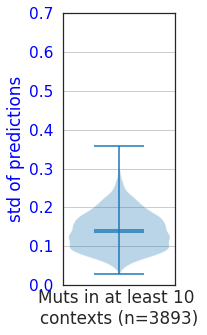

In [33]:
# Genotypes with mutations present in at least min_nb_contexts contexts
min_nb_contexts=10

col = "std"
by = "min_nb_of_contexts"

fig, ax = plt.subplots(figsize=(2, 5))
fig.patch.set_facecolor('w')

sorted_occurence_nbs = sorted(predictions_as_df[by].unique())
dataset = predictions_as_df[predictions_as_df.min_nb_of_contexts >=min_nb_contexts][[col]].values
    
ax.violinplot(dataset=dataset,showmeans=True,showmedians=True)

ax.yaxis.grid(True)
ax.set_xlabel(f"Muts in at least {min_nb_contexts} \ncontexts (n={dataset.shape[0]})")
ax.set_ylabel(col+" of predictions", color="b")
ax.tick_params(axis='y', labelcolor="b")

ax.set_xticks([min_nb_contexts])
labels = ["≥"+str(min_nb_contexts)]
ax.set_xticklabels(labels,rotation=-90)

ax.set_ylim(0,0.7)

plt.show()

# Train best architecture with muts seen in at least [min_nb_contexts] samples

## Filter training set to keep mutations found in multiple contexts

In [34]:
# filter iteratively the training and validation sets to to keep only mutations 
# present in at least "min_nb_contexts" training sample

df_thresh = pd.concat([df.loc[train_index],df.loc[valid_index]])
shape_before = df_thresh.shape

while True:
    
    df_thresh_muts = sorted(list(flatten([ elt.split(":") for elt in df_thresh[genotype_col].values.flatten()])))
    counts_in_df_thresh_muts=Counter(df_thresh_muts)

    df_thresh["min_nb_contexts"] = df_thresh[genotype_col].apply(lambda x:min([counts_in_df_thresh_muts[elt] for elt in x.split(":")]))
    
    df_thresh = df_thresh.loc[df_thresh["min_nb_contexts"]>=min_nb_contexts,:]
    
    # if no mutation is present in less than "min_nb_contexts" samples, break
    if not True in set(df_thresh["min_nb_contexts"]<min_nb_contexts):
        break

# add wild type, which gets removed otherwise
df_thresh = pd.concat([df_thresh,wt_record])
df_thresh["full_seq"] = get_seq_from_genotype.fit_transform(df_thresh)

print(shape_before,"=>",df_thresh.shape)
df_thresh.to_csv(join(modelsPath,f"{gene_name}_df_thresh.csv"))


(18932, 4) => (17002, 5)


In [35]:
predictors_thresh=predictors.loc[df_thresh.index,:]
target_thresh=target.loc[df_thresh.index,:]

## Kfold validation on filtered dataset

In [36]:
# Kfold cross validation on thresholded dataset,
# making sure model metrics are stable on several trainings

if recompute:
    
    kfold = ShuffleSplit(n_splits=5, random_state=42)
    cvscores = []


    for train, valid in kfold.split(predictors_thresh, target_thresh):

        print("intersection train and valid sets",set(train).intersection(set(valid)))

        R2_valid=-1
        while R2_valid<0:

            kfold_model = make_model()

            # Compile model
            kfold_model.compile(optimizer=optimizer,
                                loss="mean_squared_error")

            # Fit the model
            early_stopping_monitor = EarlyStopping(patience=10)
            out = kfold_model.fit(predictors_thresh.iloc[train].values,
                                  target_thresh.iloc[train].values,
                                  validation_data=(predictors_thresh.iloc[valid].values,target_thresh.iloc[valid].values),
                                  epochs=20,
                                  shuffle=True,
                                  callbacks=[early_stopping_monitor])

            # evaluate the model (R2)
            y_true = target_thresh.iloc[valid]
            y_pred = kfold_model.predict(predictors_thresh.iloc[valid].values)
            R2_valid = r2_score(y_true=y_true,y_pred=y_pred)
            if R2_valid<0:print("repeat")

        print(f"R2 {R2_valid}")
        cvscores.append(R2_valid)

    print(f"R2s mean  {np.mean(cvscores)}, R2s std {np.std(cvscores)}")


## train model on the entire thresholded dataset

In [37]:

model_file = join(modelsPath,f"{gene_name}_N1_N2_1_NN_optimized_filtered_training.h5")


try:
    if recompute:raise
    optimised_model_filtered_training = keras.models.load_model(model_file)
    print("Found",model_file)
        
except:

    # create model
    optimised_model_filtered_training=make_model()
    
    
    # Compile model
    optimised_model_filtered_training.compile(optimizer=optimizer,
                                              loss="mean_squared_error",
                                              metrics=['mae'])
    
    # Fit the model
    early_stopping_monitor = EarlyStopping(patience=10)
    checkpoint_filepath="./tmp_mdl_checkpoint"
    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                mode='min',
                                                save_best_only=True)
    
    idx_for_training = [idx for idx in train_index if idx in df_thresh.index]
    out = optimised_model_filtered_training.fit(predictors_thresh.loc[idx_for_training],
                                                target_thresh.loc[idx_for_training],
                                                validation_data=(predictors.loc[valid_index,:].values,target.loc[valid_index].values),
                                                epochs=100,
                                                shuffle=True,
                                                batch_size=100,
                                                callbacks=[early_stopping_monitor,model_checkpoint_callback])
    
    optimised_model_filtered_training.load_weights(checkpoint_filepath)

    fig, ax = plt.subplots(figsize=(10, 5))
    fig.patch.set_facecolor('w')

    plt.plot(out.history['val_loss'], 'r')
    plt.plot(out.history['loss'], 'k')

    plt.xlabel('Epochs')
    plt.ylabel('Score')

    plt.legend(("Validation set","Training set"))

    plt.show()

    optimised_model_filtered_training.save(model_file)

optimised_model_filtered_training.summary()

Found _04_Models/cgreGFP_N1_N2_1_NN_optimized_filtered_training.h5
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4720)]            0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)               944200    
_________________________________________________________________
D1 (Dropout)                 (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 200)               40200     
_________________________________________________________________
D2 (Dropout)                 (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 201       
Total params: 984,601
Trainable params: 984,601
Non-

In [38]:
# predict test set
# takes a bit of time as the model predicts 10 times each genotype
predictions_=pd.DataFrame(np.concatenate([optimised_model_filtered_training.predict(predictors_test.values) \
                                          for i in range(10)],axis=1),index=predictors_test.index)

predictions_median=pd.DataFrame(np.median(predictions_,axis=1),index=predictors_test.index,columns=["median"])
predictions_std=pd.DataFrame(predictions_.std(axis=1),index=predictors_test.index,columns=["std"])


r2 0.820


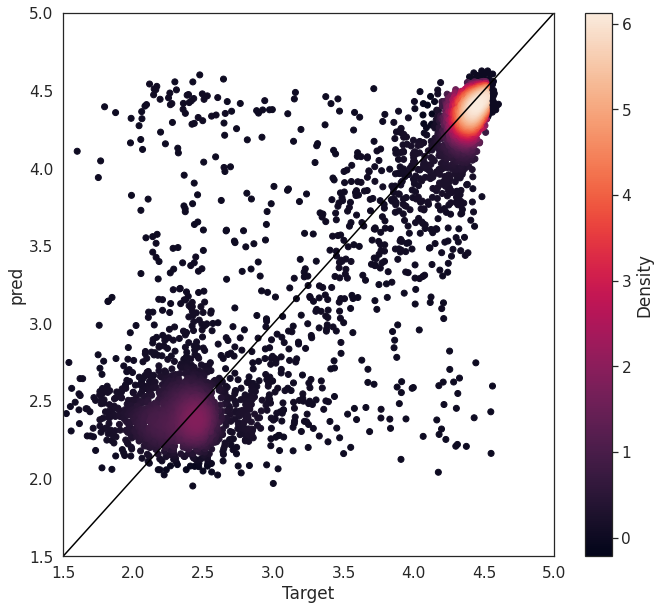

In [39]:

y_true = target.loc[test_index,:].values.flatten()
y_pred = predictions_median.values.flatten()

density_scatter(y_true,y_pred, ax = None, sort = True, bins = 20)

plt.xlim(plot_range)
plt.ylim(plot_range)
plt.xlabel("Target")
plt.ylabel("pred")

plt.plot(plot_range,plot_range,c="k")

r2_test = r2_score(y_true=y_true,y_pred=y_pred)

print("r2 %.3f" % r2_test)


The test set contains a total of 4206/4733genotypes with only trained mutations
r2 0.886


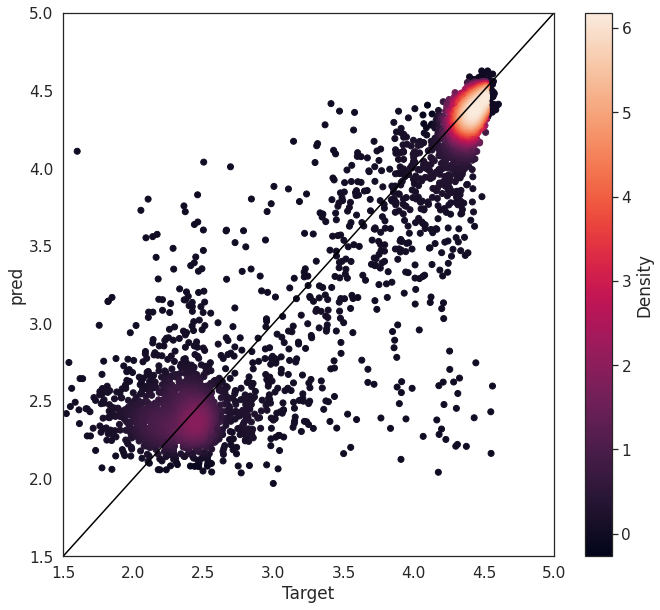

In [40]:
# Make same plot, keeping only genotypes without untrained mutations

# reminder: model was trained on df_thresh, the filtered dataset
df_thresh_muts = sorted(list(flatten([ elt.split(":") for elt in df_thresh[genotype_col].values.flatten()])))
df_thresh_muts_unique = sorted(list(set(df_thresh_muts)))

test_index_with_trained_muts=[]
for ID,row in df.loc[test_index].iterrows():
    mutations = row[genotype_col].split(":")
    keep=True
    for mut in mutations:
        if mut not in df_thresh_muts_unique:
            keep=False
    if keep:
        test_index_with_trained_muts.append(ID)

print((f"The test set contains a total of {len(test_index_with_trained_muts)}/{len(test_index)}"
       "genotypes with only trained mutations"))

y_true = target.loc[test_index_with_trained_muts,:].values.flatten()
y_pred = predictions_median.loc[test_index_with_trained_muts,:].values.flatten()

density_scatter(y_true,y_pred, ax = None, sort = True, bins = 20)
if gene_name=="avGFP":plot_range=(1.3,5)

plt.xlim(plot_range)
plt.ylim(plot_range)
plt.xlabel("Target")
plt.ylabel("pred")

plt.plot(plot_range,plot_range,c="k")

r2_test = r2_score(y_true=y_true,y_pred=y_pred)
print("r2 %.3f" % r2_test)


In [41]:
results=pd.DataFrame({"Predicted fluorescence":y_pred,"Observed fluorescence":y_true})

results.to_csv(f"{figuresPath}for_paper/{gene_name}_optimised.csv")